## Reproduce Published osmFISH results with Starfish

osmFISH is an image based transcriptomics technique that can spatially resolve tens of RNA transcripts and their expression levels in-situ. The protocol anddata analysis are described in this [publication](https://www.nature.com/articles/s41592-018-0175-z). This notebook walks through how to use Starfish to process the raw images from an osmFISH experiment into a spatially resolved gene expression image. We verify taht Starfish can accurately reproduce the results from the authors' original Python [pipeline](http://linnarssonlab.org/osmFISH/image_analysis/)

Please see [documentation](https://spacetx-starfish.readthedocs.io/en/stable/index.html) for detailed descriptions of all the data structures and methods used here.

In [10]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from starfish import FieldOfView, data
from starfish.types import Axes

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data into Starfish from the Cloud

The data from an osmFISH experiment are similar in form to a standard smFISH experiment. For each round, each color channel corresponds to presence of a particular gene. Across rounds, the color channels index different genes. Here, we analyze one FOV from the first round (r) channel (c) which consists of 45 z-planes (z). Each image in this image stack is of dimensions 2048x2048 (y X x). The data are taken from mouse somatosensory cortex, and the gene in this channel is Adloc

In [13]:
experiment = data.osmFISH(use_test_data=True)
imgs = experiment["fov_000"].get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

100%|██████████| 45/45 [00:02<00:00, 21.35it/s]

<starfish.ImageStack (r: 1, c: 1, z: 45, y: 2048, x: 2048)>


## Filter and Visualize Data

First, we remove background signal using a gaussian high-pass filter

In [16]:
filter_ghp = starfish.image.Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
imgs_ghp = filter_ghp.run(imgs, in_place=False)

Next, we enhance the spots by filtering with a Laplace filter

In [17]:
filter_laplace = starfish.image.Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)
imgs_ghp_laplace = filter_laplace.run(imgs_ghp, in_place=False)

Finally, we take a maximum projection over z then select the 1st `(0)` channel for visualization in the notebook to demonstrate the effect of background removal using these filters.

In [18]:
mp = stack_ghp_laplace.max_proj(Axes.ZPLANE)

100%|██████████| 1/1 [00:00<00:00, 108.15it/s]


We can now visualize our data before and after filtering

100%|██████████| 1/1 [00:00<00:00, 127.10it/s]


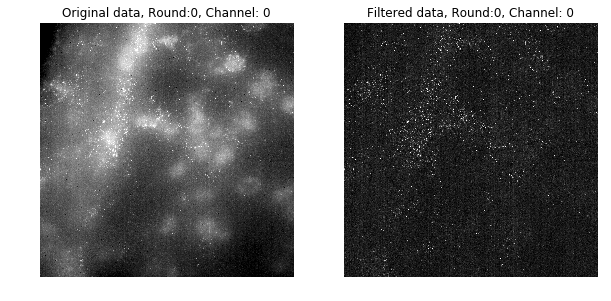

In [38]:
single_plane = imgs.max_proj(Axes.ZPLANE).xarray.sel({Axes.CH:0}).squeeze()
single_plane_filtered = mp.xarray.sel({Axes.CH: 0}).squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [1, 99.8])))
plt.axis('off')
plt.title('Original data, Round:0, Channel: 0')
plt.subplot(122)
plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [1, 99.9])))
plt.title('Filtered data, Round:0, Channel: 0')
plt.axis('off');

### Spot Finding

osmFISH uses a peak finder that distinguishes local maxima from their surroundings whose absolute intensities exceed a threshold value. It tests a number of different thresholds, building a curve from the number of peaks detected at each threshold. A threshold in the _stable region_ of the curve is selected, and final peaks are called with that threshold.

This process is repeated independently for each round and channel. Here we show this process on a single round and channel to demonstrate the procedure.

In [9]:
lmp = starfish.spots.SpotFinder.LocalMaxPeakFinder(
    min_distance=6,
    stringency=0,
    min_obj_area=6,
    max_obj_area=600,
)
spot_intensities = lmp.run(mp)

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:26<00:20,  2.14it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...


Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, i

KeyboardInterrupt: 

### Spot finding QA

Select spots in the first round and channel and plot their intensities

In [ ]:
aldoc_spot_intensities = spot_intensities.sel({Axes.ROUND.value: 0, Axes.CH.value: 0})

plt.hist(aldoc_spot_intensities, bins=20)
plt.yscale("log")
plt.xlabel("Intensity")
plt.ylabel("Number of spots");

Starfish enables maximum projection and slicing of the ImageStack object. However, these projections will maintain the 5d shape, leaving one-length dimensions for any array that has been projected over. Here the maximum projection of the z-plane of the ImageStack is calculated. From it, the first channel and round are selected, and `squeeze` is used to eliminate any dimensions with only one value, yielding a two-dimension `(x, y)` tile that can be plotted.

In [ ]:
maximum_projection_5d = stack_ghp_laplace.max_proj(Axes.ZPLANE)
maximum_projection_2d = mp.sel({Axes.CH: 0, Axes.ROUND: 0}).xarray.squeeze()

Use the maximum projection to plot all spots detected by starfish:

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(
    maximum_projection_2d,
    cmap = "gray",
    vmin=np.percentile(maximum_projection_2d, 98),
    vmax=np.percentile(maximum_projection_2d, 99.9),
)
plt.plot(spot_intensities[Axes.X.value], spot_intensities[Axes.Y.value], "or")
plt.axis("off");

## Compare to pySMFISH peak calls

The Field of view that we've used for the test data corresponds to Aldoc, imaged in round one, in position 33. We've also packaged the results from the osmFISH publication for this target to demonstrate that starfish is capable of recovering the same results.

In [ ]:
def load_results(pickle_file):
    with open(pickle_file, "rb") as f:
        return pickle.load(f)

def get_benchmark_peaks(loaded_results, redo_flag=False):

    if not redo_flag:
        sp = pd.DataFrame(
            {
                "y":loaded_results["selected_peaks"][:,0],
                "x":loaded_results["selected_peaks"][:,1],
                "selected_peaks_int": loaded_results["selected_peaks_int"],
            }
        )
    else:
        p = peaks(loaded_results)
        coords = p[p.thr_array==loaded_results["selected_thr"]].peaks_coords
        coords = coords.values[0]
        sp = pd.DataFrame({"x":coords[:,0], "y":coords[:,1]})

    return sp

try:
    module_path = __file__
except NameError:
    # this is probably being run from jupyter
    cwd = "."
else:
    cwd = os.path.dirname(module_path)
benchmark_results = load_results(os.path.join(
    cwd, "data", "EXP-17-BP3597_hyb1_Aldoc_pos_33.pkl"))
benchmark_peaks = get_benchmark_peaks(benchmark_results, redo_flag=False)

Plot spots detected in the benchmark as blue spots, and overlay spots from starfish as orange x's. Starfish detects the same spot positions, but 41 fewer spots in total.

In [ ]:
benchmark_spot_count = len(benchmark_peaks)
starfish_spot_count = len(spot_intensities)

plt.figure(figsize=(10,10))
plt.plot(benchmark_peaks.x, -benchmark_peaks.y, "o")
plt.plot(spot_intensities[Axes.X.value], -spot_intensities[Axes.Y.value], "x")

plt.legend(["Benchmark: {} spots".format(benchmark_spot_count),
            "Starfish: {} spots".format(starfish_spot_count)])
plt.title("Starfish x osmFISH Benchmark Comparison");

In [ ]:
spot_difference = benchmark_spot_count - starfish_spot_count
print(f"Starfish finds {spot_difference} fewer spots")
assert spot_difference == 41  # for starfish testing purposes